### Xente Fraud Detection Challenge

#### Goal
The goal of this project is to create a machine learning model to detect fraudulent transactions.


#### Introduction

Xente is an e-payments, e-commerce, and financial services company in Uganda offering various products and services that can be paid for using Mobile Money (Airtel Money, MTN Mobile Money), Bank Card (Visa Card, Master Card), Xente wallet and on credit (Pay Later). Some of the products consumers can buy include airtime, data bundles, pay water and electricity bills, TV subscription services, buy event tickets, movie tickets, bus tickets, and more.

#### Evaluation
The error metric for this competition is the F1 score, which ranges from 0 (total failure) to 1 (perfect score). Hence, the closer your score is to 1, the better your model.

F1 Score: A performance score that combines both precision and recall. It is a harmonic mean of these two variables. Formula is given as: 2*Precision*Recall/(Precision + Recall)

Precision: This is an indicator of the number of items correctly identified as positive out of total items identified as positive. Formula is given as: TP/(TP+FP)

Recall / Sensitivity / True Positive Rate (TPR): This is an indicator of the number of items correctly identified as positive out of total actual positives. Formula is given as: TP/(TP+FN)

Where:

TP=True Positive
FP=False Positive
TN=True Negative
FN=False Negative

### Evaluation metric

For obvious reasons we strive to have a high recall, thus not letting fraud slip through.
Still, precision cannot be left out, otherwise we would have angry legitimate customers, that cannot make payments.
We therefore pick a metric that measures both, both weighted toward recall: 

### Importing the libraries

In [5]:
# pip install Tensorflow

In [6]:
# pip install imblearn

In [80]:
import pandas as pd # data handling
import numpy as np

from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from datetime import datetime

# Sampling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

#### 2. Exploring the data

    2.1. Checking for how many rows and columns
    2.2. Checking for the column names how many rows and columns
    2.3. Checking for type of data present in the dataframe
    2.4. Checking for null values in each column
    2.5. Checking for unique values
    2.6. Finding the descriptive statistics
    2.7. Checking for duplicates
    2.8. Checking for data imbalance
    2.9. Plotting histogram for float/integer features
    2.10. Correlation heat map
    2.11. Checking for outliers
  

In [2]:
df_train = pd.read_csv("data/train_data.csv", sep = ",")

In [3]:
# reading the data set
df_train.head(2)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,"1,000.00",1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.00,20,2018-11-15T02:19:08Z,2,0


In [4]:
#Checking for how many rows and columns
df_train.shape

(95662, 16)

In [5]:
#Checking for the column names
df_train.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [6]:
#Checking for null values in each column
df_train.isnull().sum()

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64

In [7]:
# Checking for type of data present in the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [8]:
# Checking for unique values
df_train.nunique()

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

In [9]:
# Finding the descriptive statistics
df_train.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,"95,662.00","95,662.00","95,662.00","95,662.00","95,662.00"
mean,256.00,"6,717.85","9,900.58",2.26,0.00
std,0.00,"123,306.80","123,122.09",0.73,0.04
min,256.00,"-1,000,000.00",2.00,0.00,0.00
25%,256.00,-50.00,275.00,2.00,0.00
50%,256.00,"1,000.00","1,000.00",2.00,0.00
75%,256.00,"2,800.00","5,000.00",2.00,0.00
max,256.00,"9,880,000.00","9,880,000.00",4.00,1.00


In [10]:
# Checking for duplicates

def check_duplicates(data):
    has_dup = data.duplicated()
    true_dup = np.where(has_dup == True)
    if len(true_dup[0]) > 0:
        print("Data has", len(true_dup[0]), "duplicates")
    else:
        print("No duplicates found !!!")

check_duplicates(df_train)

No duplicates found !!!


In [11]:
df_train.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
95657    False
95658    False
95659    False
95660    False
95661    False
Length: 95662, dtype: bool

In [12]:
# Checking for data imbalance
df_train['FraudResult'].value_counts()

0    95469
1      193
Name: FraudResult, dtype: int64

In [13]:
#Checking skewness
df_train.skew()

CountryCode        0.00
Amount            51.10
Value             51.29
PricingStrategy    1.66
FraudResult       22.20
dtype: float64

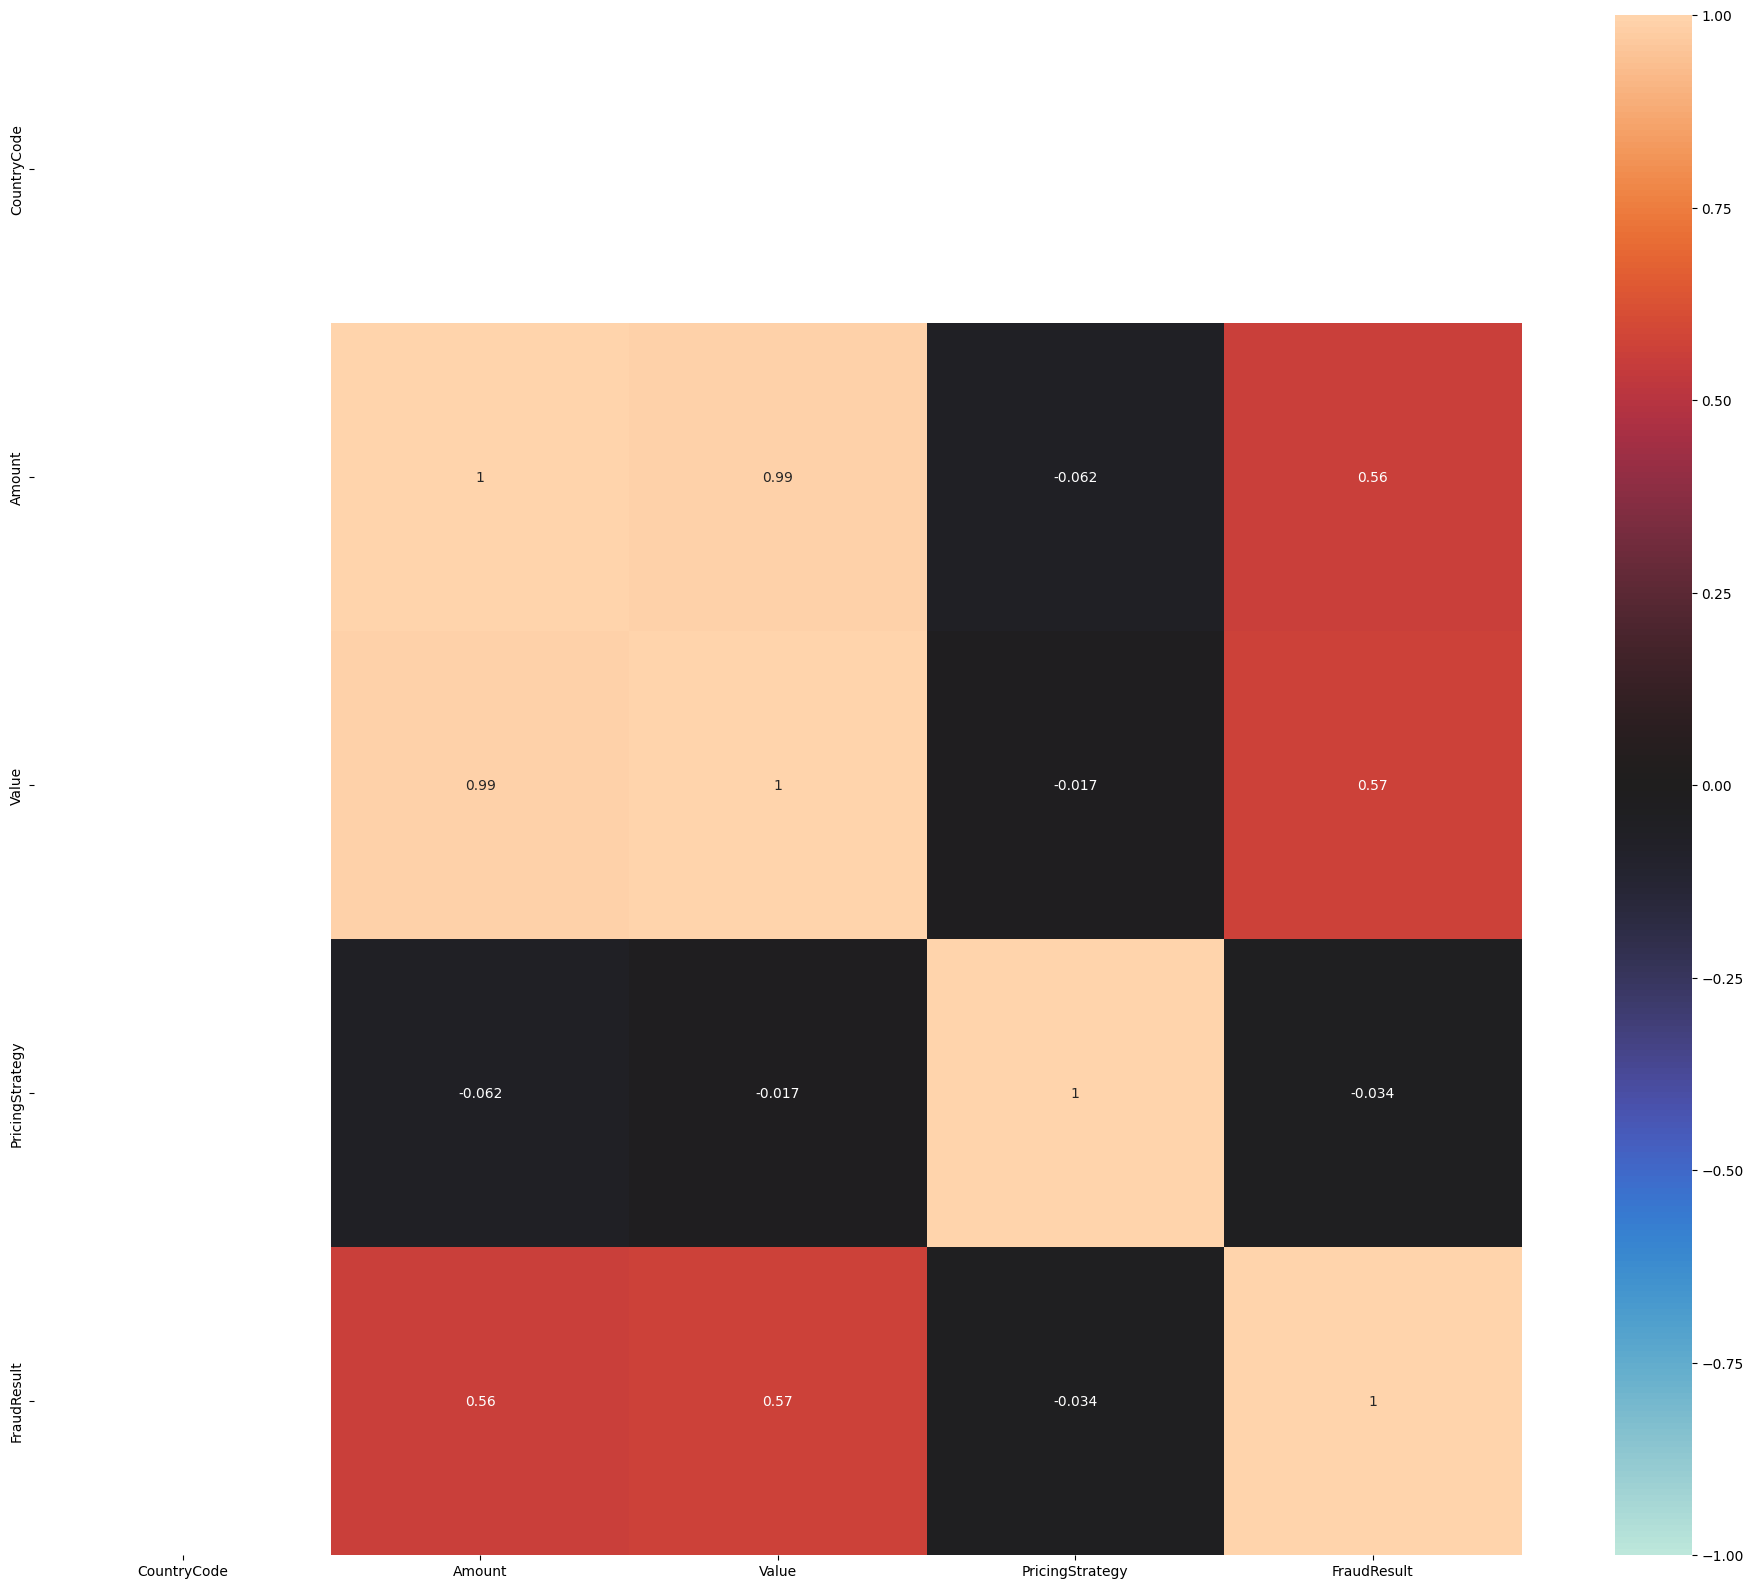

<Figure size 800x500 with 0 Axes>

In [14]:
plt.figure(figsize=[24,20])
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()
plt.savefig('images/1.png');

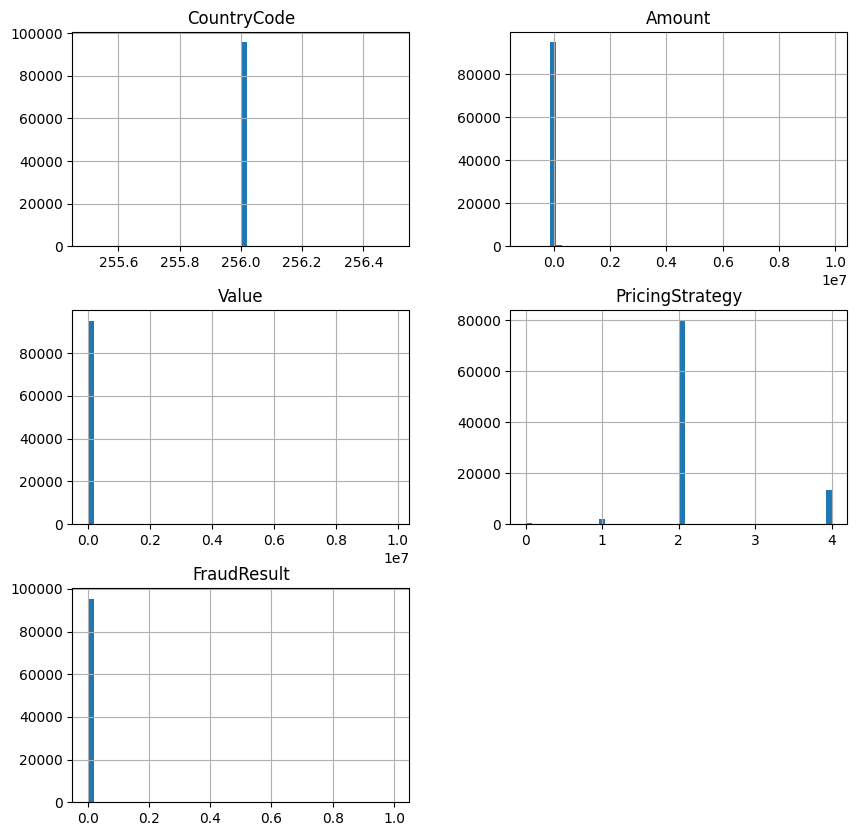

In [15]:
# Plotting histogram for float/integer features 
df_train.hist(bins=50, figsize=(10,10))
plt.savefig('images/2.png');

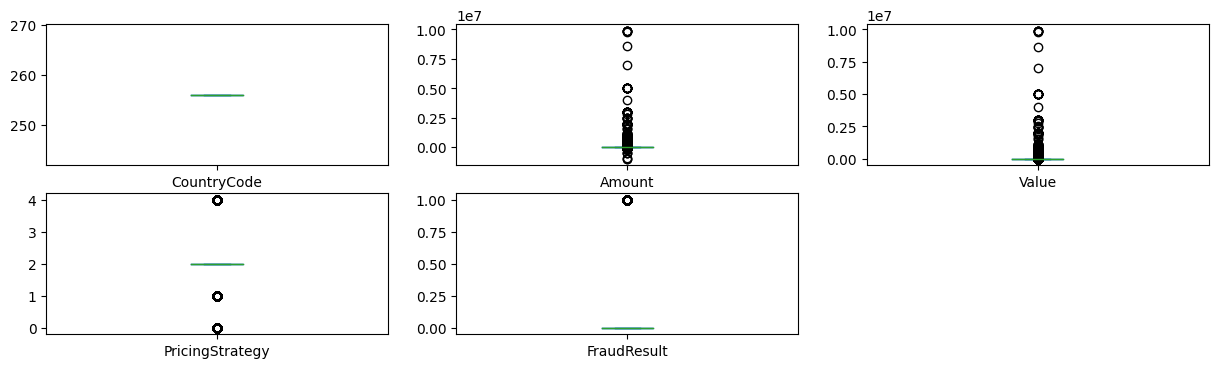

In [16]:
# Checking for Outliers
df_train.plot(kind='box', subplots=True, layout=(7,3), figsize=(15,15)) #
plt.savefig('images/2.png');

In [17]:
df_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,"1,000.00",1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.00,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.00,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,"20,000.00",21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.00,644,2018-11-15T03:34:21Z,2,0


#### Cleaning the data

In [18]:
id_cols = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ChannelId']

df_train[id_cols] = df_train[id_cols].applymap(lambda x: x.split('_')[1]).astype('int')

df_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,3,"1,000.00",1000,2018-11-15T02:18:49Z,2,0
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,2,-20.00,20,2018-11-15T02:19:08Z,2,0
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,3,500.00,500,2018-11-15T02:44:21Z,2,0
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,3,"20,000.00",21800,2018-11-15T03:32:55Z,2,0
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,2,-644.00,644,2018-11-15T03:34:21Z,2,0


In [19]:
# Changing Time to datetime stamp 

df_train = df_train.assign(
    timestamp = lambda x: pd.to_datetime(x['TransactionStartTime']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    hour = lambda x: x['timestamp'].dt.hour,
    minute = lambda x: x['timestamp'].dt.minute
    #dayofweek = lambda x: x['TransactionStartTime'].dt.dayofweek
)

In [20]:
df_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,Value,TransactionStartTime,PricingStrategy,FraudResult,timestamp,year,month,day,hour,minute
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,...,1000,2018-11-15T02:18:49Z,2,0,2018-11-15 02:18:49+00:00,2018,11,15,2,18
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,...,20,2018-11-15T02:19:08Z,2,0,2018-11-15 02:19:08+00:00,2018,11,15,2,19
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,...,500,2018-11-15T02:44:21Z,2,0,2018-11-15 02:44:21+00:00,2018,11,15,2,44
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,...,21800,2018-11-15T03:32:55Z,2,0,2018-11-15 03:32:55+00:00,2018,11,15,3,32
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,...,644,2018-11-15T03:34:21Z,2,0,2018-11-15 03:34:21+00:00,2018,11,15,3,34


#### Analysing the data

In [21]:
# fig = sns.pairplot(data=df_train, hue='FraudResult')
# # plt.savefig("figures/pairplot.png")

<AxesSubplot:xlabel='SubscriptionId', ylabel='Amount'>

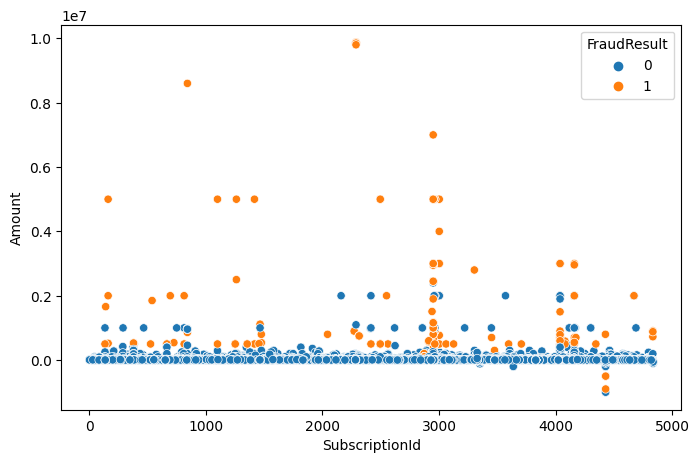

In [22]:
sns.scatterplot(data=df_train, x='SubscriptionId', y='Amount', hue='FraudResult')

#### Product category vs Amount of transaction

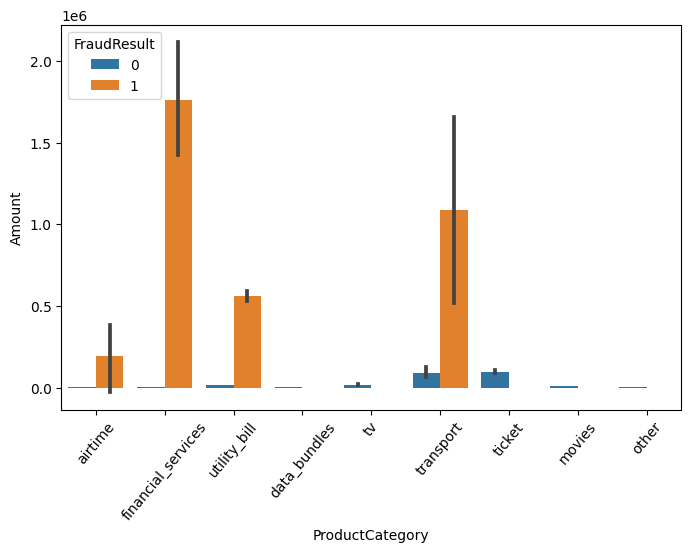

In [23]:
sns.barplot(x = 'ProductCategory', y = 'Amount',  hue='FraudResult', data = df_train)
plt.xticks(rotation=50, size=10);

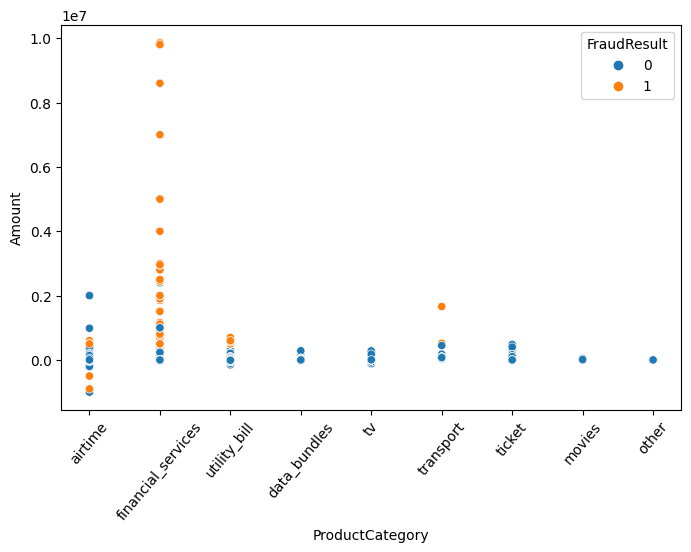

In [24]:
sns.scatterplot(x = 'ProductCategory', y = 'Amount',  hue='FraudResult', data = df_train)
plt.xticks(rotation=50, size=10);

#### Channelid

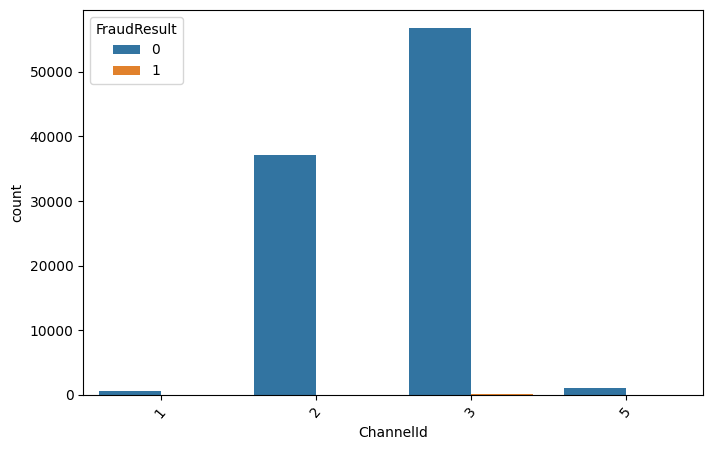

In [25]:
sns.countplot(data=df_train, x='ChannelId', hue='FraudResult')
plt.ylabel('count')
plt.xticks(rotation=50);

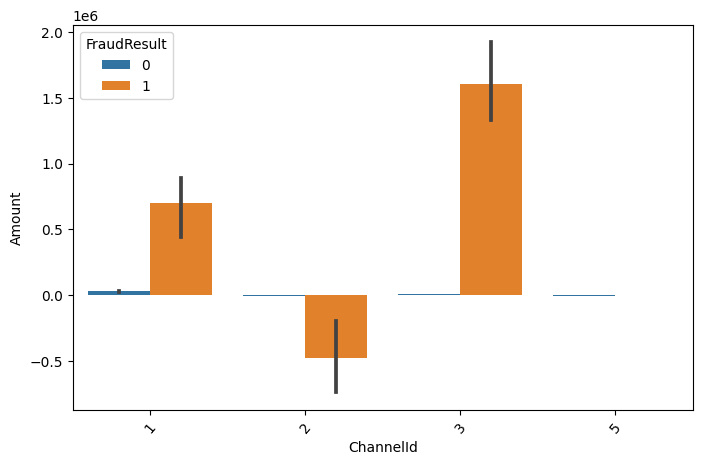

In [26]:
sns.barplot(x = 'ChannelId', y = 'Amount', hue='FraudResult', data = df_train)
plt.xticks(rotation=50, size=10);

#### Fraud count of product id, account id and customer id

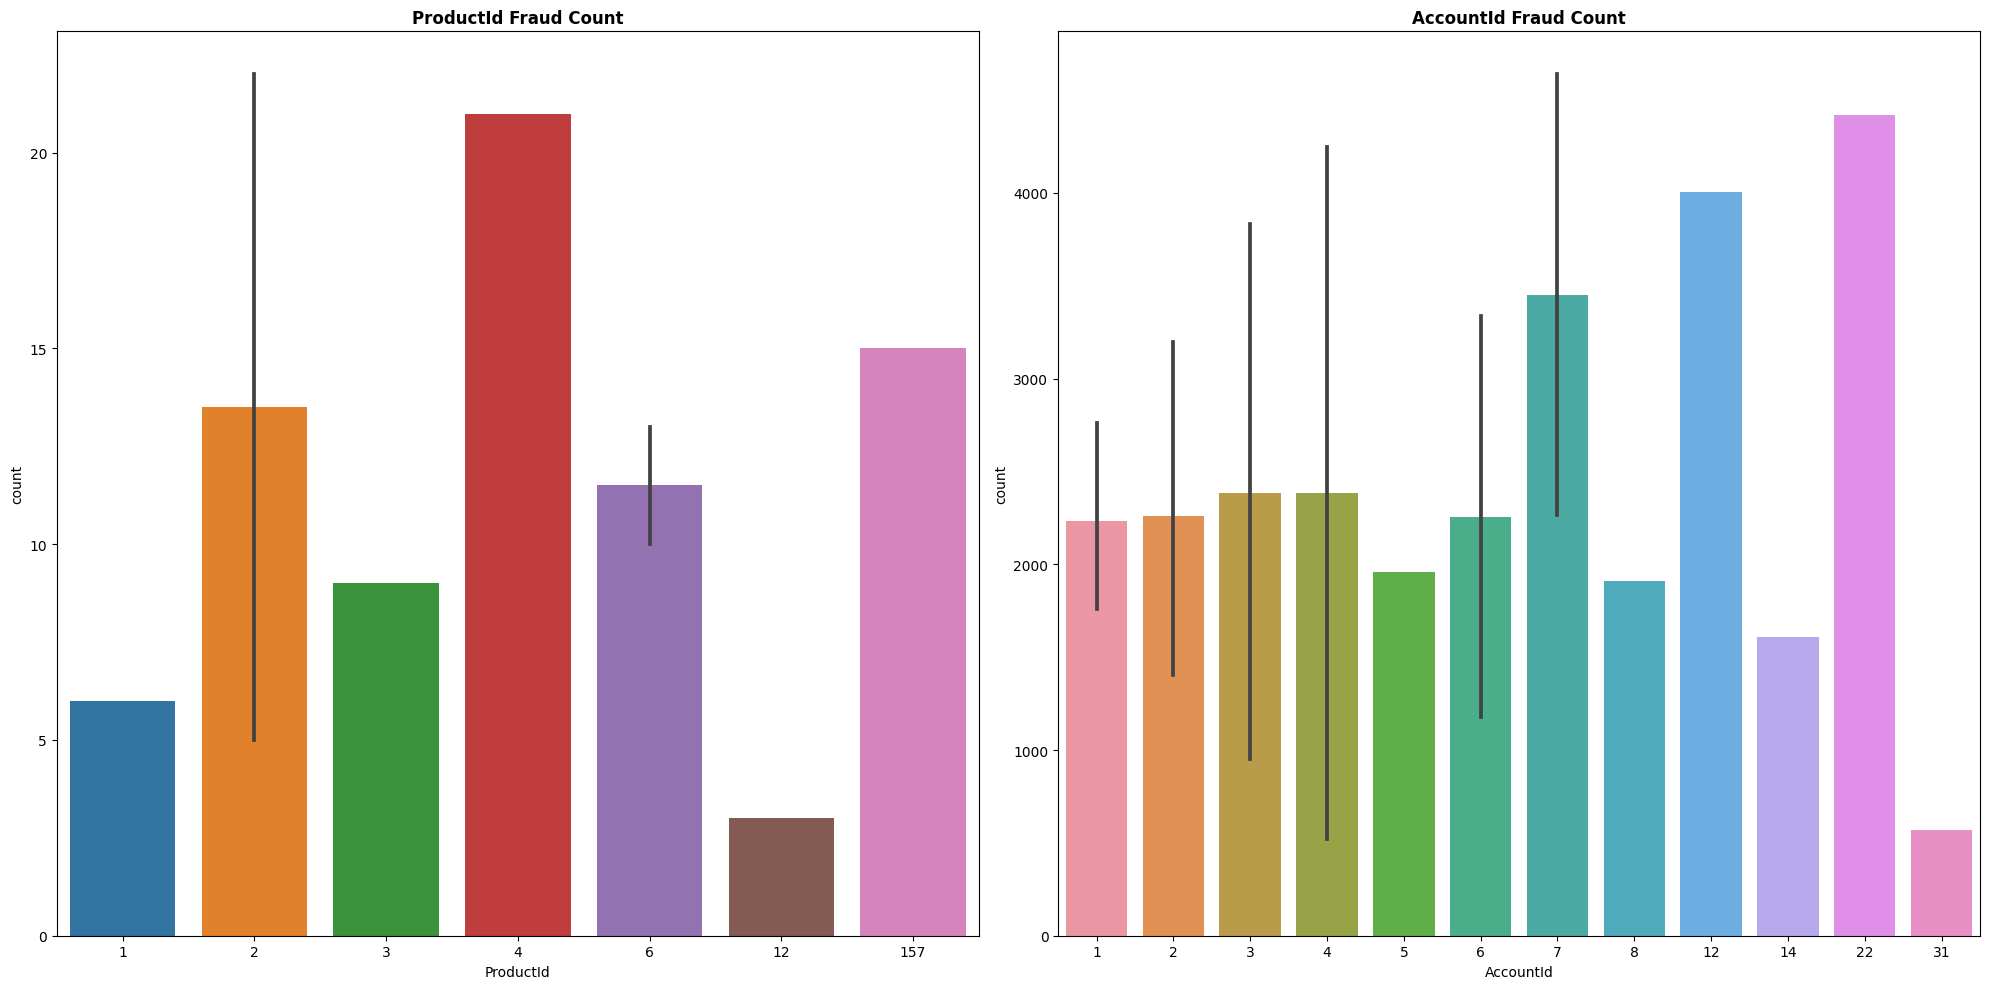

In [27]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.barplot(
    y = df_train[df_train.FraudResult == 1].ProductId.value_counts().index,
    x = df_train[df_train.FraudResult == 1].ProductId.value_counts().values,
)
plt.title('ProductId Fraud Count', fontweight='bold')
plt.ylabel('count')
plt.xlabel('ProductId')

plt.subplot(1, 2, 2)
sns.barplot(
    y = df_train[df_train.FraudResult == 1].AccountId.value_counts().index,
    x = df_train[df_train.FraudResult == 1].AccountId.value_counts().values,
)
plt.title('AccountId Fraud Count', fontweight='bold')
plt.ylabel('count')
plt.xlabel('AccountId')

# plt.subplot(2, 2, 3)
# sns.barplot(
#     y = df_train[df_train.FraudResult == 1].CustomerId.value_counts().index,
#     x = df_train[df_train.FraudResult == 1].CustomerId.value_counts().values,
# )
# plt.title('CustomerId Fraud Count', fontweight='bold')
# plt.ylabel('count')
# plt.xlabel('CustomerId')

plt.tight_layout()
plt.show()

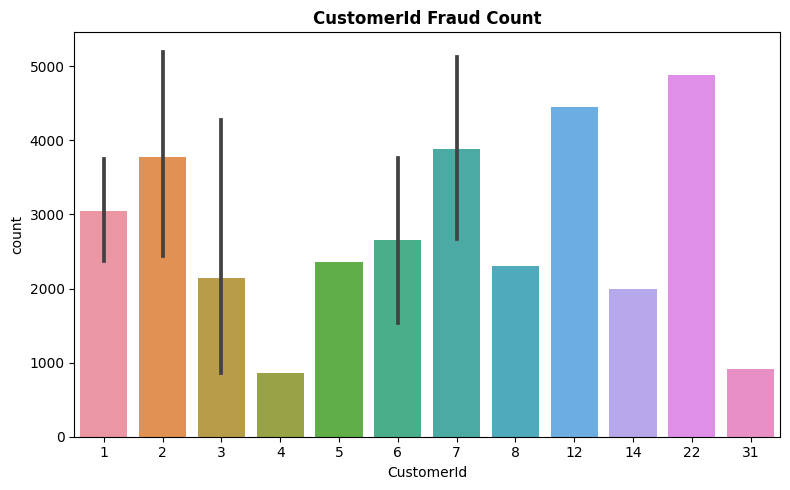

In [28]:

sns.barplot(
    y = df_train[df_train.FraudResult == 1].CustomerId.value_counts().index,
    x = df_train[df_train.FraudResult == 1].CustomerId.value_counts().values,
)
plt.title('CustomerId Fraud Count', fontweight='bold')
plt.ylabel('count')
plt.xlabel('CustomerId')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Non-Fraudulent Transaction Count for Each Hour')

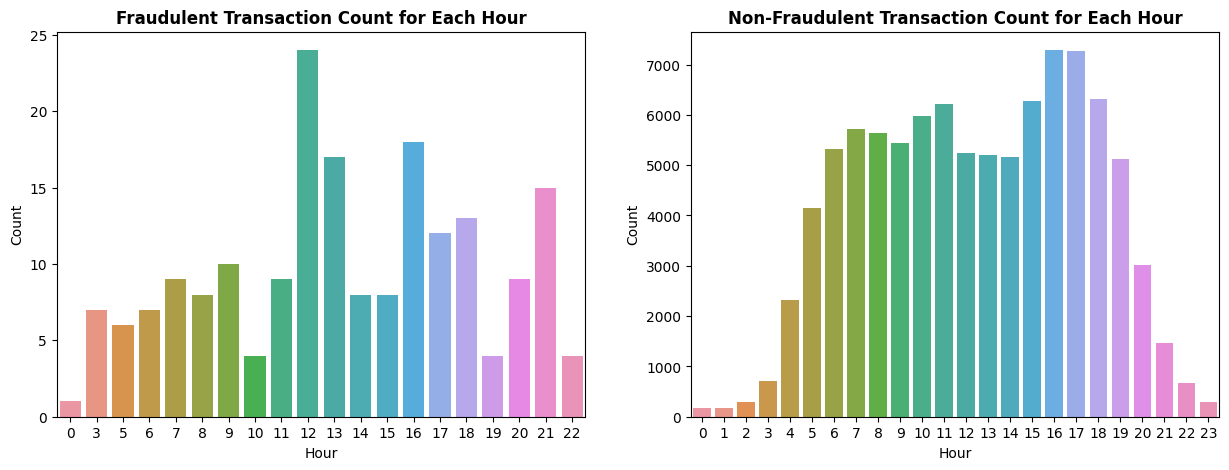

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(
    x=df_train[df_train.FraudResult == 1].hour.value_counts().sort_index().index,
    y=df_train[df_train.FraudResult == 1].hour.value_counts().sort_index().values
)

plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Fraudulent Transaction Count for Each Hour', fontweight='bold')
#plt.savefig('figures/Fraudulent Transaction.png', bbox_inches='tight')

plt.subplot(1, 2, 2)
sns.barplot(
    x=df_train[df_train.FraudResult == 0].hour.value_counts().sort_index().index,
    y=df_train[df_train.FraudResult == 0].hour.value_counts().sort_index().values
)

plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Non-Fraudulent Transaction Count for Each Hour', fontweight='bold')
#plt.savefig('figures/Non-Fraudulent Transaction.png', bbox_inches='tight')

### Saving the dataframe for preocessing and data modelling

In [30]:
df_train.to_csv("data/train_clean.csv")

#### Baseline Model

In [31]:
df_train_baseline = pd.read_csv("data/train_clean.csv", sep = ",")

In [32]:
df_train_baseline.columns

Index(['Unnamed: 0', 'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId',
       'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'timestamp',
       'year', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [33]:
#Dropping the Unnamed column
df_train_baseline.drop(["Unnamed: 0", "CurrencyCode", "ProductCategory", "TransactionStartTime", "timestamp"], axis=1, inplace=True)

In [34]:
# #Changing categorical values
# df_train_baseline = pd.get_dummies(df_train_baseline)

In [35]:
y = df_train_baseline['FraudResult']
X = df_train_baseline.drop('FraudResult', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Original dataset  ---> ',X.shape,y.shape,'\nTraining set  ---> ', X_train.shape,y_train.shape,
'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original dataset  --->  (95662, 17) (95662,) 
Training set  --->  (66963, 17) (66963,) 
Testing set   --->  (28699, 17)  (28699,)


In [36]:
df_train_baseline.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CountryCode,ProviderId,ProductId,ChannelId,Amount,Value,PricingStrategy,FraudResult,year,month,day,hour,minute
0,76871,36123,3957,887,4406,256,6,10,3,"1,000.00",1000,2,0,2018,11,15,2,18
1,73770,15642,4841,3829,4406,256,4,6,2,-20.00,20,2,0,2018,11,15,2,19
2,26203,53941,4229,222,4683,256,6,1,3,500.00,500,2,0,2018,11,15,2,44
3,380,102363,648,2185,988,256,1,21,3,"20,000.00",21800,2,0,2018,11,15,3,32
4,28195,38780,4841,3829,988,256,4,6,2,-644.00,644,2,0,2018,11,15,3,34


In [37]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [38]:
#We can access the following properties to view the coefficient for the slope and y-intercept of the best fitting line.
print(lr.coef_)
print(lr.intercept_)

[[-1.07342223e-06 -4.97692611e-06 -8.22297686e-05 -1.96724386e-04
   5.00743500e-05 -3.82692596e-04 -9.00718717e-06 -2.14274437e-06
  -4.49636778e-06 -6.77311219e-06  1.42627529e-05 -4.13683687e-06
  -3.01756688e-03 -8.33712410e-06 -2.80495110e-05 -1.54792827e-05
  -4.50833153e-05]]
[-1.49489297e-06]


In [39]:
# Let’s see how the model performs against data that it hasn’t been trained on.
y_pred = lr.predict(X_test)

In [40]:
lr.predict_proba(X_test)

array([[9.98843477e-01, 1.15652288e-03],
       [9.99340952e-01, 6.59048437e-04],
       [9.99474734e-01, 5.25265717e-04],
       ...,
       [9.99507539e-01, 4.92461076e-04],
       [9.99583286e-01, 4.16714466e-04],
       [9.98951234e-01, 1.04876626e-03]])

In [41]:
print(f"F3 score = {fbeta_score(y_test, y_pred, beta=3).round(4)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F3 score = 0.2607
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28643
           1       0.42      0.25      0.31        56

    accuracy                           1.00     28699
   macro avg       0.71      0.62      0.66     28699
weighted avg       1.00      1.00      1.00     28699

[[28624    19]
 [   42    14]]


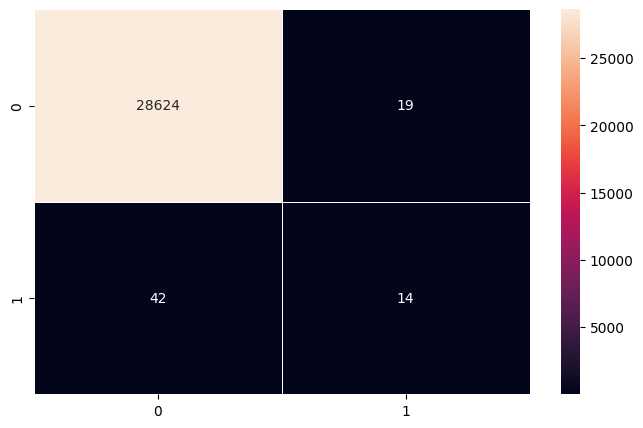

In [42]:
# Confusion matrix using confusion_matrix from sklearn
cfm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', linewidths=.5);


### Preprocessing of the Data before Modelling

In [43]:
df2_train = pd.read_csv("data/train_clean2.csv", sep = ",")

In [44]:
#Dropping columns
df2_train.drop(["Unnamed: 0", "CurrencyCode", "TransactionStartTime", "timestamp"], axis=1, inplace=True)

In [45]:
#Changing categorical values
df2_train = pd.get_dummies(df2_train)
#df2_train

In [46]:
y = df2_train['FraudResult']
X = df2_train.drop('FraudResult', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Original dataset  ---> ',X.shape,y.shape,'\nTraining set  ---> ', X_train.shape,y_train.shape,
'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original dataset  --->  (95662, 26) (95662,) 
Training set  --->  (66963, 26) (66963,) 
Testing set   --->  (28699, 26)  (28699,)


### Feature Engineering

#### Scaling

In [47]:
col_scale = ['Amount', 'Value', 'PricingStrategy']

scl = StandardScaler()
X_train[col_scale] = scl.fit_transform(X_train[col_scale])
X_test[col_scale] = scl.transform(X_test[col_scale])

print(X_train.shape)
print(X_test.shape)

(66963, 26)
(28699, 26)


#### Sampling the imbalanced data

### SMOTE

In [48]:
sm = SMOTE(random_state=RSEED)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print(X_train_smote.shape)
print(X_train.shape)

(133652, 26)
(66963, 26)


In [49]:
sm = SMOTE(random_state=RSEED)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print(X_train_smote.shape)
print(X_train.shape)

(133652, 26)
(66963, 26)


### Adasyn

In [50]:
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

print(X_train_ada.shape)
print(X_train.shape)

(133701, 26)
(66963, 26)


### BorderlineSMOTE

In [51]:

border = BorderlineSMOTE(random_state=42)
X_train_border, y_train_border = border.fit_resample(X_train, y_train)

print(X_train_border.shape)
print(y_train_border.shape)

(133652, 26)
(133652,)


In [52]:
y_train_smote.head(2)

0    0
1    0
Name: FraudResult, dtype: int64

#### Ploting the imbalanced data and sampled with SMOTE

Text(0.5, 1.0, 'Imbalanced Data')

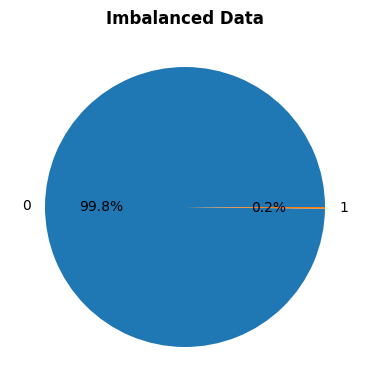

In [53]:
y= df2_train['FraudResult']


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.pie(
    df2_train.FraudResult.value_counts().values,
    labels = df2_train.FraudResult.value_counts().index,
    autopct='%1.1f%%'
)
plt.title('Imbalanced Data', fontweight='bold')

# plt.subplot(2, 2, 2)
# plt.pie(
#     y_train_smote.FraudResult.value_counts().values,
#     labels = y_train_smote.FraudResult.value_counts().index,
#     autopct='%1.1f%%'
# )
# plt.title('Oversampled Data', fontweight='bold')
#plt.savefig('figures/Sampling.png', bbox_inches='tight')

### Modelling

### Logistic Regression

In [55]:
# logistic regression
model_lr = LogisticRegression()
model_lr.fit(X_train_smote, y_train_smote)
y_pred = model_lr.predict(X_test)

print(f"F3 score = {fbeta_score(y_test, y_pred, beta=3).round(4)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F3 score = 0.0863
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     28643
           1       0.01      0.77      0.02        56

    accuracy                           0.85     28699
   macro avg       0.50      0.81      0.47     28699
weighted avg       1.00      0.85      0.91     28699

[[24210  4433]
 [   13    43]]


### Naive Bayes

In [60]:
# Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train_smote, y_train_smote)
y_pred = model_nb.predict(X_test)

print(f"F3 score = {fbeta_score(y_test, y_pred, beta=3).round(4)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F3 score = 0.8034
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28643
           1       0.58      0.84      0.69        56

    accuracy                           1.00     28699
   macro avg       0.79      0.92      0.84     28699
weighted avg       1.00      1.00      1.00     28699

[[28609    34]
 [    9    47]]


### KNN

In [61]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
model_knn.fit(X_train_smote, y_train_smote)
y_pred = model_knn.predict(X_test)

print(f"F3 score = {fbeta_score(y_test, y_pred, beta=3).round(4)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F3 score = 0.0271
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     28643
           1       0.00      0.12      0.01        56

    accuracy                           0.93     28699
   macro avg       0.50      0.53      0.48     28699
weighted avg       1.00      0.93      0.96     28699

[[26567  2076]
 [   49     7]]


### Random Forest

In [73]:
clf=RandomForestClassifier(n_jobs = -1, random_state = 42, n_estimators = 200, verbose = 1)
clf.fit(X_train_smote, y_train_smote)
rf_predictions = clf.predict(X_test)

print(f"F3 score = {fbeta_score(y_test, rf_predictions, beta=3).round(4)}")
print(classification_report(y_test, rf_predictions))
print(confusion_matrix(y_test, rf_predictions))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished


F3 score = 0.7937
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28643
           1       0.71      0.80      0.76        56

    accuracy                           1.00     28699
   macro avg       0.86      0.90      0.88     28699
weighted avg       1.00      1.00      1.00     28699

[[28625    18]
 [   11    45]]


### Random Forest with Grid Search CV 

In [ ]:
f3_score = make_scorer(fbeta_score, beta=3)
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 25, 50],
    #'min_sample_split': [2, 3, 5, 10],
    'min_impurity_decrease': [0, .05, .1, .15, .2],
}

rfc = RandomForestClassifier() 
gs_forest = GridSearchCV(rfc, param_grid, scoring=f3_score, cv=5, n_jobs=-1, verbose=5)
gs_forest.fit(X_train_smote, y_train_smote)

In [79]:
y_pred = gs_forest.best_estimator_.predict(X_test)
print(gs_forest.best_params_)
print(f"F3 score = {fbeta_score(y_test, y_pred, beta=3).round(4)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

{'max_depth': 50, 'min_impurity_decrease': 0, 'n_estimators': 300}
F3 score = 0.8113
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28643
           1       0.73      0.82      0.77        56

    accuracy                           1.00     28699
   macro avg       0.86      0.91      0.89     28699
weighted avg       1.00      1.00      1.00     28699

[[28626    17]
 [   10    46]]


### XG Boost

In [81]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train_smote, y_train_smote)

[15:12:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print(f"F3 score = {fbeta_score(y_test, y_pred, beta=3).round(4)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

F3 score = 0.8627
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28643
           1       0.77      0.88      0.82        56

    accuracy                           1.00     28699
   macro avg       0.88      0.94      0.91     28699
weighted avg       1.00      1.00      1.00     28699

[[28628    15]
 [    7    49]]


### XGBoost with Grid Search CV 

In [ ]:
# param_grid = {
#     'booster': ['gbtree', 'gblinear', 'dart'],
#     # 'max_depth': [5,6,7], # default = 6
#     # 'max_delta_step': np.arange(0, 7,2), # default = 0
#     #'lambda': [0, 1],
#     'num_parallel_tree': [1, 2, 3],
#     'learning_rate': [.2, .3, .4], # default = .3
# }

# xgb = XGBClassifier(verbosity=2)
# gs_xgb = GridSearchCV(xgb, param_grid, scoring=f3_score, cv=5, n_jobs=-1, verbose=5)
# gs_xgb.fit(X_train_smote, y_train_smote)

In [86]:
# y_pred = gs_xgb.best_estimator_.predict(X_test)

# print(f"F3 score = {fbeta_score(y_test, y_pred, beta=3).round(4)}")
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

F3 score = 0.8627
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28643
           1       0.77      0.88      0.82        56

    accuracy                           1.00     28699
   macro avg       0.88      0.94      0.91     28699
weighted avg       1.00      1.00      1.00     28699

[[28628    15]
 [    7    49]]


### Model Evaluation

### Fraud Detection of the Test Data 

In [87]:
df_test = pd.read_csv("data/test.csv", sep = ",")

In [88]:
df_test.head(2)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,"1,000.00",1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,"2,000.00",2000,2019-02-13T10:02:12Z,2


In [108]:
df_test.shape

(45019, 26)

### Preprocessing

In [93]:
id_cols2 = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ChannelId']

df_test[id_cols2] = df_test[id_cols2].applymap(lambda x: x.split('_')[1]).astype('int')

df_test.head(2)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,50600,35028,2441,4426,2857,UGX,256,5,3,airtime,3,"1,000.00",1000,2019-02-13T10:01:40Z,4
1,95109,45139,3439,2643,3874,UGX,256,5,15,financial_services,3,"2,000.00",2000,2019-02-13T10:02:12Z,2


In [94]:
# Changing Time to datetime stamp 

df_test = df_test.assign(
    timestamp = lambda x: pd.to_datetime(x['TransactionStartTime']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    hour = lambda x: x['timestamp'].dt.hour,
    minute = lambda x: x['timestamp'].dt.minute
    #dayofweek = lambda x: x['TransactionStartTime'].dt.dayofweek
)

In [96]:
#Dropping columns
df_test.drop(["CurrencyCode", "TransactionStartTime", "timestamp"], axis=1, inplace=True)

In [98]:
#Changing categorical values
df_test = pd.get_dummies(df_test)
df_test.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CountryCode', 'ProviderId', 'ProductId', 'ChannelId', 'Amount',
       'Value', 'PricingStrategy', 'year', 'month', 'day', 'hour', 'minute',
       'ProductCategory_airtime', 'ProductCategory_data_bundles',
       'ProductCategory_financial_services', 'ProductCategory_movies',
       'ProductCategory_retail', 'ProductCategory_ticket',
       'ProductCategory_transport', 'ProductCategory_tv',
       'ProductCategory_utility_bill'],
      dtype='object')

### Testing with XGBoost

In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train_smote, y_train_smote)

In [103]:
# make predictions for test data
y_pred1 = model.predict(df_test)
predictions = [round(value) for value in y_pred1]

In [104]:
results = pd.DataFrame({'Predicted': predictions})
print(results)

       Predicted
0              1
1              1
2              1
3              1
4              1
...          ...
45014          1
45015          1
45016          1
45017          1
45018          1

[45019 rows x 1 columns]


In [106]:
df_test2 = pd.read_csv('data/test.csv')
prediction = pd.DataFrame(y_pred1)
Fraud_results = df_test2[['TransactionId', 'BatchId']].join(prediction).drop('BatchId', axis=1)
Fraud_results.columns=['TransactionId', 'FraudResult']

Fraud_results.to_csv('data/prediction_test.csv', index=False)

In [112]:
Fraud_results.FraudResult.value_counts()

1    44982
0       37
Name: FraudResult, dtype: int64

In [113]:
clf=RandomForestClassifier(n_jobs = -1, random_state = 42, n_estimators = 200, verbose = 1)
clf.fit(X_train_smote, y_train_smote)
rf_predictions = clf.predict(df_test)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


In [114]:
results = pd.DataFrame({'Predicted': rf_predictions})
print(results)

       Predicted
0              1
1              1
2              1
3              1
4              1
...          ...
45014          0
45015          1
45016          0
45017          0
45018          1

[45019 rows x 1 columns]


In [116]:
df_test2 = pd.read_csv('data/test.csv')
prediction = pd.DataFrame(rf_predictions)
Fraud_results = df_test2[['TransactionId', 'BatchId']].join(prediction).drop('BatchId', axis=1)
Fraud_results.columns=['TransactionId', 'FraudResult']

#Fraud_results.to_csv('data/prediction_test.csv', index=False)

In [117]:
Fraud_results.FraudResult.value_counts()

1    25377
0    19642
Name: FraudResult, dtype: int64